# Maximum Entropy Inverse Reinforcement Learning

The code in this notebook is based on the Maximum Entropy Inverse Reinforcement Learning paper by Ziebart et al. (2008).

_Disclaimer:_
The code provided in this notebook is written for readability.
In some sections, this has a considerable impact on performance:
Many operations, especially the ones involving the transition probability $P(s_k \mid s_i, a_j)$, can be reformulated as a combination or series of matrix multiplications. For an implementation considering these optimizations have a look at the accompanying python files.

## Introduction

While I assume some familiarity with the basics of reinforcement and inverse reinforcement learning, here's a short overview (so feel free to skip this part if you already know them):
In both settings, we describe our world using a Markov decision process (MDP).
A MDP is a 5-tuple $(S, A, T, R, \gamma)$ with states $S$, actions $A$, transition model $T(s_t, a_t, s_{t+1}) = p(s_{t+1} \mid s_t, a_t)$, reward function $R(s_t, a_t, s_{t+1}) \in \mathbb{R}$, and reward discount factor $\gamma \in [0, 1]$ decreasing the reward over time (where $a_t \in A$ and $s_t, s_{t+1} \in S$).
In the inverse reinforcement learning setting we will only use per-state rewards $R(s) \in \mathbb{R}$.
The key part of an MDP is that any action only relies on the current state, meaning complete independence of all of the preceding history.

The goal of reinforcement learning (RL) is to find an optimal sequence of actions, i.e. a policy describing the optimal action per state, for an autonomous agent given a reward signal $R$.
The reward signal provides feedback to the agent, affirming its behavior on actions that help further the goal of the task at hand, and punishing it on actions that are counter-productive to this goal.
Policies come in two flavors: deterministic and stochastic.
Deterministic policies are defined as function $\pi: S \to A$, whereas stochastic policies are defined as probability distributions over actions, i.e. $\pi(a \mid s)$.
While in the usual RL setting the (or at least one) optimal policy is guaranteed to be deterministic, in inverse reinforcement learning (and not only there), it also makes sense to talk about stochastic policies.

Inverse reinforcement learning (IRL), as the name states, does exactly the inverse of RL.
Given a set of demonstrations $\mathcal{D} = \{\tau_i\}_{i=1}^{n}$ of an expert (agent), consisting of trajectories $\tau = \left( (s_1, a_1), (s_2, a_2), \ldots, (s_{n-1}, a_{n-1}), s_n \right)$ through the state-action space, IRL aims to recover the underlying reward function which explains the behavior of the expert.

To allow for computation with states, we use so-called features.
Features are, in this case, defined as a function $\phi: S \to \mathbb{R}^d$, mapping states to $d$-dimensional vectors, and can be arbitrarily chosen.
In general, we assume that $\phi(\tau) = \sum_{t = 1}^{|\tau|} \phi(s_t)$ where $|\tau|$ denotes the length of the trajectories (visited states), i.e. that the features of a trajectory $\tau$ are the sum of the features of the states visited by this trajectory, counting repetitions.

### The Principle of Maximum Entropy

The general idea of Maximum Entropy Inverse Reinforcement Learning is based on feature-expectation matching [\[Abbel & Ng 2004\]](#References):
The expected visitation-frequency of features in the demonstrations provided by the expert should equal the exected visitation-frequency of features visited by the agent following the recovered reward function.
In other words: The features describing the states of our world should be, in expectance, visited equally often by the agent following our recovered reward function and by the expert demonstrating (nearly) optimal behavior.
In equations, we can express this as the expectation of features $\phi$ over trajectories $\tau$ derived from the reward we want to recover, and 

$$
    \mathbb{E}_{\pi^L}[\phi(\tau)] = \mathbb{E}_{\pi^E}[\phi(\tau)],
$$

where the learner follows a policy $\pi^L$ directly implied by the reward.
The expert follows an implicit policy $\pi^E$ that encodes its notion of reward and optimality.
Note that we can also express the expected feature visitation frequency as sum over trajectories

$$
    \mathbb{E}_{\pi^L}[\phi(\tau)] = \sum_{\tau} p_{\pi^L}(\tau) \phi(\tau)
$$

with the probability distribution $p_{\pi^L}(\tau)$ of trajectories of the learner. Finding such a match, however, is not a well-posed problem in accordance to the definition by Hadamard: There is not the single one, but many possible solutions.
Multiple reward functions can achieve the same expected feature-visitation frequency [\[Ng et al. 99; Abbel & Ng 2004; Ziebart 2010\]](#References).
To resolve this ambiguity, Ziebart et al. [\[Ziebart et al. 2008\]](#References). propose to choose the solution (i.e. the $p_{\pi^L}$) maximizing the entropy.

But why should we maximize the entropy?
To answer this, we have to understand what entropy represents.
First of all, the entropy $H(p)$ of some event probability distribution $p$ is defined as

$$
    H(p)
    = -\sum_{x \in \mathcal{X}} p(x) \log_2 p(x)
    = \sum_{x \in \mathcal{X}} p(x) \cdot \log_2 \frac{1}{p(x)},
$$

where $X$ is the set containing all events $x$ and $p(x)$ the probability of event $x$ occurring.
Let us now assume that we want to communicate the occurrence of all events $x$ with some other party in an efficient manner.
To do this, we want to minimize the expected message length, so messages that will be sent frequently should be short, and messages that will be sent almost never are allowed to be long.
Following this trail of thought leads to the term $h(x) = \log_2(1/p(x))$, which is the optimal number of bits that we should spend on the message representing event $x$.
With lower probability $p(x)$, the term $\log_2(1/p(x))$ increases.
In fact it increases logarithmically, as with more bits available, we can encode exponentially more events.
Using this observation for the entropy $H$ then yields nothing more than the entropy being the lower limit of the expected message length over all messages, i.e.:

$$
    H(p)
    = \mathbb{E}_{p(x)}\left[h(x)\right].
$$

Summarizing all of this in a single sentence: Entropy is a measure of uncertainty.
Note that this is in fact the underlying principle of Huffman coding (which, due to this relation, is guaranteed to be optimal9.
As is done generally, we instead of the logarithm to base two use the normal logarithm.
Since $\log_2(x) = \log(x)/\log(2)$ holds, we are only dropping a constant factor of $\log(2)$ which does not impact extremas or our reasoning below, and simplifies further computations.

With that in mind, let us ask again:
Why should we maximize the entropy?
Now we can give a simple reasoning [\[Jaynes 1957\]](#References):
Let us assume that we have two distributions, $p_1$ and $p_2$, with entropies $H(p_1) > H(p_2)$.
From our previous observations, we know now that to encode messages from $p_1$ we, in expectancy, need more bits than to encode messages from $p_2$.
This is the key point, because this in turn also means that we have less information about $p_1$ than about $p_2$.
If we know more about a distribution, we need less bits to encode events from it.
If we know everything, we do not need to send/encode anything, and if we know nothing, we need to send everything.

But isn't it good if we know more? The less entropy the better, right? you may ask.
No.
Not for many optimization problems, or in general, when working with incomplete information:
Consider a problem, like feature-expectation matching, which has multiple solutions fullfilling our constraints.
The only information which we give our solver for this problem is the feature-expectations we want to replicate.
All solutions provided by our solver contain this information.
Yet they most certainly have a different entropy values.
This must mean that (at least) some solutions have additional information that we did not provide, i.e. they have a bias.
By choosing the solution with maximum entropy, we choose the solution with minimal information.
Note that all solutions already satisfy our constraints, thus we actually choose the solution that fits our information with a minimal bias.

### Deriving the Maximum Entropy Inverse Reinforcement Learning Algorithm

Applying our findings from the previous section to feature-expectation matching directly results in a constrained optimization problem:

$$
\DeclareMathOperator{\argmax}{arg\,max}
\begin{alignat*}{2}
    \argmax_p\quad
        && H(p) \\
    \text{subject to}\quad
        && \mathbb{E}_{\pi^L}[\phi(\tau)] &= \mathbb{E}_{\pi^E}[\phi(\tau)],
            \tag{feature-expectation matching} \\
        && \sum_{\tau} p(\tau) = 1, &\quad \forall \tau : p(\tau) &> 0
            \tag{probability constraints}
\end{alignat*}
$$

This problem expresses that we want to find a probability distribution $p(\tau)$ over trajectories $\tau$ with maximum entropy, under which the expected feature visitation frequencies of learner $\mathbb{E}_{\pi^L}[\phi(\tau)]$ and expert $\mathbb{E}_{\pi^E}[\phi(\tau)]$ match (that $\phi(\tau)$ represents the features visited by trajectory $\tau$).
Note that the policy $\pi^L$ of the learner depends on the probability distribution $p(\tau)$:

$$
    \pi^L(a \mid s) \propto \sum_{\tau :\ (s, a) \in \tau_{t=0}} p(\tau),
    \tag{1}
$$

i.e. the policy of the learner is proportional to the sum of the probabilities of all trajectories performing action $a$ in the starting state $s$.

Now we have the probability distribution over trajectories, but how does this help us to recover the reward function $R: S \to \mathbb{R}$?
Following the school of basic reinforcement learning provides us with the answer: The reward dictates the policy, which in turn dictates the trajectory distribution $p(\tau)$.
A key assumption of Maximum Entropy IRL is that we know the behavior of our MDP, i.e. we have a perfect model representing the transition probabilities $p(s_{t+1} \mid s_t, a_t)$, so the only thing we actually need to learn is the reward.
Everything else either is derived from it or assumed known.
To be able to learn the reward, we need to parameterize it.
For this we assume linearity with regards to features, i.e.

$$
    R(\tau) = \omega^\top \phi(\tau)
$$

with $\omega \in \mathbb{R}^d$ being the reward parameter vector.
To make the dependency on the reward parameters explicit, we write $p(\tau \mid \omega)$ (and $\pi(a \mid s, \omega)$).

The choice of a linear parametrization is not by chance, but a direct result of the feature expectation matching constraint:
Given an expert solving an MDP with unknown reward function linear in a set of known features, performing feature expectation matching with those features is guaranteed to yield a policy performing comparable to or better than the expert with respect to the reward [\[Abbeel & Ng 2004\]](#References).

#### Solution and Partition Function

Solving the above mathematical program for MDPs with deterministic transition dynamics (i.e. MDPs where all actions have predetermined deterministic outcomes) using the method of Lagrange multipliers leads to the observation that

$$
    p_d(\tau \mid \omega) = \frac{1}{Z(\omega)} \exp \left( \omega^\top \phi(\tau) \right),
    \qquad
    Z(\omega) = \sum_{\tau} \exp \left( \omega^\top \phi(\tau) \right)
$$

with the so-called partition function $Z(\omega)$ simply normalizing the values to fullfill the probability distribution constraint [\[Ziebart et al. 2008; Osa et al. 2018\]](#References).
By choosing the reward to linearly depend on the features, we have also ensured that the Lagrange multipliers are exactly the reward parameters $\omega$ [\[Osa et al. 2018\]](#References).
For MDPs with stochastic transitions, Ziebart et al. [\[Ziebart et al. 2008\]](#References) propose to modify the deterministic solution yielding the approximation

$$
    p_s(\tau \mid \omega)
    \approx
        \frac{1}{Z(\omega)} \exp\left( \omega^\top \phi(\tau) \right)
        \prod_{s_{t+1}, a_t, s_t \in \tau} p(s_{t+1} \mid s_t, a_t).
    \tag{2}
$$

Note that we're simply multiplying the deterministic solution with combined transition probability of the trajectory.
As a result of said modification, however, we introduce a bias to the reward function [\[Osa et al. 2018\]](#References).
To avoid this, Ziebart [\[Ziebart 2010\]](#References) proposes the Maximum Causal Entropy IRL method in his thesis.
In the scope of this notebook, we'll stick to the normal (non-causal) entropy.

#### Optimization

We now know the parameterized form of the distribution, so how can we optimize the parameters?
The answer is fairly straightforward: We can maximize the log-likelihood over all demonstrated trajectories $\mathcal{D} = \{\tau_i\}_{i=1}^{N}$, i.e.

$$
\DeclareMathOperator*{\argmax}{arg\,max}
    \omega^* = \argmax_{\omega} \mathcal{L}(\omega)
    = \argmax_{\omega} \sum_{\tau \in \mathcal{D}} \log p(\tau \mid \omega),
$$

using gradient ascent (or any other gradient-based optimization technique) as this function is convex [\[Ziebart et al. 2008; Osa et al. 2018\]](#References).
A small side-note: Maximizing the log-likelihood is equivalent to minimizing the Kullback-Leibler divergence $D_{KL}(p^E(\tau) \,\|\, p(\tau \mid \omega))$ [\[Bishop 2006\]](#References), so it can also be interpreted as the M-projection onto the manifold of the maximum entropy distribution [\[Osa et al. 2018\]](#References).
The (averaged) gradient is then simply the difference between expected empirical feature counts $\mathbb{E}_{\pi^E} \left[ \phi(\tau) \right]$ and the learners expected feature counts (derived from the trajectory probabilities $p(\tau \mid \omega)$), i.e. ([Equation (3a)](#Optimization))

$$
\begin{align*}
    \nabla_\omega \mathcal{L}(\omega)
    &= \mathbb{E}_{\pi^E} \left[ \phi(\tau) \right] - \sum_{\tau} p(\tau \mid \omega)\ \phi(\tau)
        \tag{3a}\\
    &= \mathbb{E}_{\pi^E} \left[ \phi(\tau) \right] - \sum_{s_i} D_{s_i} \phi(s_i),
        \tag{3b}\\
\end{align*}
$$

which we can express in terms of the state-visitation frequency $D_{s_i}$ ([Equation (3b)](#Optimization)), assuming $\phi(\tau) = \sum_{t = 0}^{|\tau|} \phi(s_t)$ [\[Ziebart et al. 2008\]](#References).
Note that (due to the log-likelihood) this gradient holds for both deterministic and stochastic transition dynamics.

#### Computing the State-Visitation Frequency

Now, we have only one remaining question:
How do we compute the state-visitation frequency $D_{s_i}$?
Following good computer-science fashion, we divide and conquer:
First, we compute a (stochastic) policy $\pi(a \mid s, \omega)$ (referred to as the local action probability) with a backward pass, after which we compute the state-visitation frequency under this policy with a simple forward pass.
While the second part is fairly straightforward (as will become apparent by the code below), the first certainly benefits of a small explanation.

The basic idea of the first pass is to remember our earlier observation about the learner policy $\pi^L(a \mid s)$ ([Equation (1)](#Deriving-the-Maximum-Entropy-Inverse-Reinforcement-Learning-Algorithm)), and then recursively expand this using the solution we derived for our trajectory distribution $p(\tau \mid \omega)$ ([Equation (2)](#Solution-and-Partition-Function)) until we are not reasoning about full or partial trajectories any more, but the individual state transitions.
This then yields the set of equations [\[Ziebart et al. 2008\]](#References)

$$
    \pi(a_j \mid s_i, \omega) = \frac{Z_{s_i, a_j}}{Z_{s_j}}
    ,\quad
    Z_{s_i, a_j} = \sum_{k} p(s_k \mid s_i, a_j)\, \exp \left(\omega^\top \phi(s_i)\right)\, Z_{s_k}
    ,\quad
    Z_{s_i} = \sum_{a_j} Z_{s_i, a_j}.
$$

Here, $Z_{s_i}$ represents the state-partition-function, again normalizing the probabilities, and $Z_{s_i, a_i}$ is referred to as the state-action partition function.
Setting the state-partition function $Z_{s_i} = 1$ for terminal states and then recursively backing up, using the equations for $Z_{s_i}$ and $Z_{s_i, a_j}$, from those states yields a set of values that we can then use to compute the local action probabilities following the above equation.

This backup-pass somewhat resembles a value-iteration scheme to solve an MDP.
It turns out that this backup part of the algorithm is the only thing that differs between Maximum Entropy and Maximum Causal Entropy IRL.
In fact, for the Maximum Causal Entropy approach, one can show that the partition functions are an analogy of the Bellman equation, the so-called soft Bellman equation, which allows for a straightforward extension of the value-iteration algorithm to this problem [\[Ziebart 2010\]](#References).

This concludes the prequisites we need to know for our implementation.

### The Plan Forward

Before we actually begin with the code, let's do a quick recap:
First of all, we have some preparation to do.
As prequisites, we need an MDP (a world) which we can use for demonstration (which also provides us with some features) and some trajectories provided by an expert (which we here simulate).
We need to compute the feature-expectancy for the given trajectories, and inside our optimization loop we need to compute the expected state-visitation frequency, for which we also need the probability of states being starting-points (based on the trajectories), as well as perform a gradient-ascent optimization step.
For most of the boilerplate code, specifically for the MDP, trajectory-generation, the actual optimization step, and plotting, we will re-use the code from the accompanying `src` directory.

Now let's get started.

## Preparations

First off, the imports: We need the usual external dependencies for calcualtion and plotting:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product               # Cartesian product for iterators

and our framework to hide the boring stuff:

In [2]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../src/irl_maxent')))

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

Let's also use interactive javascript-based plots and pre-define a global style for plotting:

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

### MDP and Trajectories

Now, let's create our MDP.
We're using a square grid-world, i.e. a world with $5 \times 5$ states where an agent can move to any of the four adjacent states.
If the agent would move over an edge, it will stay in the same state, in any other case, the agent will always move to another state.
To introduce stochastic transition dynamics, our agent has a $20\%$ probability of "slipping", meaning that it will choose a random action instead of the one selected.
Note that this is not a full MDP as defined above, we just need the main components, i.e. the states, actions, and transition model via the `world`, the reward (per state) and a list of terminal states.

In [4]:
def setup_mdp():
    # create our world
    world = W.IcyGridWorld(size=6, p_slip=0.2)

    # set up the reward function
    reward = world.reward
    reward[-1] = 1.0
    reward[12] = 0.8

    # set up terminal states
    terminal = world.terminal

    return world, reward, terminal

# set-up the GridWorld Markov Decision Process
world, reward, terminal = setup_mdp()

We also need some trajectories from which we can learn.
Normally, they would be provided by experts, but here we will simulate them using a stochastic policy derived via standard value iteration.

In [8]:
def generate_expert_trajectories(world, reward, terminal):
    n_trajectories = 30     # the number of "expert" trajectories
    discount = 0.9               # discount for constructing an "expert" policy
    weighting = lambda x: x**50  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value = S.value_iteration(world.p_transition, reward, discount)
    
    # create our stochastic policy using the value function
    policy = S.stochastic_policy_from_value(world, value, w=weighting)
    
    # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = T.stochastic_policy_adapter(policy)
    
    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))
    
    return tjs, policy

# generate some "expert" trajectories (and its policy for visualization)
trajectories, expert_policy = generate_expert_trajectories(world, reward, terminal)

Let's have a look at our world via the reward (left), expert policy (right) and trajectories (right, transparent white lines).
The terminal state is the upper-right state, the initial state for the trajectories is the lower-left state.

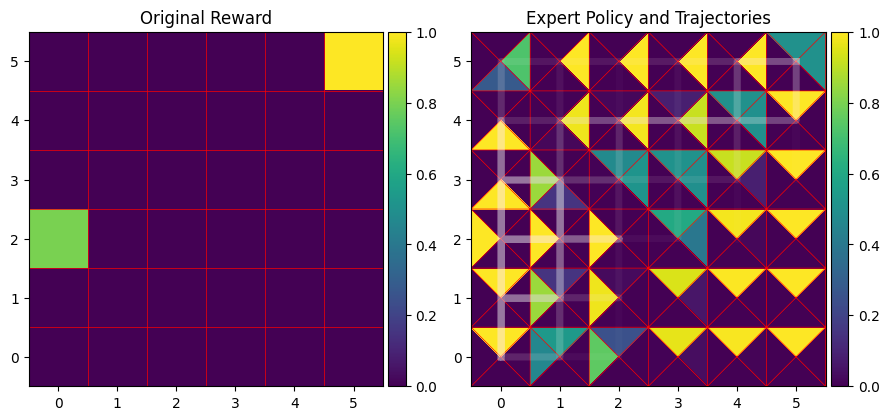

In [9]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_stochastic_policy(ax, world, expert_policy, **style)
fig.colorbar(p, cax=cax)

for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)

fig.tight_layout()
plt.show()

With that done, we have all the prequisites we need to run the actual algorithm.

## The Actual Algorithm

Let's start with the easy parts:
Remember that the gradient we need to compute for optimization is

$$
    \nabla_\omega \mathcal{L}(\omega)
    = \underbrace{\mathbb{E}_{\pi^E} \left[ \phi(\tau) \right]}_{(1)}
        - \underbrace{\sum_{s_i} D_{s_i} \phi(s_i)}_{(2)},
$$

so we first need to get the feature expectation $\mathbb{E}_{\pi^E} \left[ \phi(\tau) \right]$ (part (1)) from the trajectories of our trainings-set $\mathcal{D}$.
This is fairly simple, as for each trajectory we just need to check which states are going to be visited, sum the features of these states up (counting repetitions), and then at the end average over all trajectories, i.e.

$$
    \mathbb{E}_{\pi^E} \left[ \phi(\tau) \right]
    = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{s_t \in \tau} \phi(s_t)
$$

or as a function:

In [10]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

Another fairly simple thing we need to know about the trajectories is the probability of a state being a starting state, $p(s_0)$.
This is required for the state-visitation-frequency $D_{s_i}$ which we in turn need for part (2) of the gradient.
Here, we just count the number of trajectories starting in each state and then normalize with the number of trajectories.

In [11]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories)            # normalize

With that we're ready to look at the algorithm computing the expected state visitation frequency (this is Algorithm 1 in the Maximum Entropy IRL paper by Ziebart et al. [\[Ziebart et al. 2008\]](#References)).
As already mentioned above, this algorithm consists of two parts: A backward pass computing the local action probabilities $\pi(a \mid s, \omega)$ and a forward pass computing the state visitation frequencies $D_{s_i}$ from those.

For the **backward-pass** we recursively back-up from terminal states (initialized with $Z_{s_i} = 1$), computing the state and state-action partition functions $Z_{s_i}$ and $Z_{s_i, a_j}$.
When we have those, we can compute the local action probability using $\pi(a_j \mid s_i, \omega)$.
A technical issue we stumble accross here, is that this process does not converge.
To this end, we choose to run $2 \cdot |S|$ iterations, as this ensures the maximum trajectory length is covered ($|S|$) and we have some slack.
As explained previously, the equations we need for this are

$$
    \pi(a_j \mid s_i, \omega) = \frac{Z_{s_i, a_j}}{Z_{s_j}}
    ,\quad
    Z_{s_i, a_j} = \sum_{k} p(s_k \mid s_i, a_j)\, \exp \left(\omega^\top \phi(s_i)\right)\, Z_{s_k}
    ,\quad
    Z_{s_i} = \sum_{a_j} Z_{s_i, a_j}.
$$

For the **forward-pass** we initialize the state-visitation frequency with the probability of a state being a starting-point (`p_initial` $= p(s_0)$).
To compute the state-visitation-frequency for another state, we just sum up the transition probabilities of (direct) transitions to this other state multiplied by the state-visitation frequency of the origin-state of this transition, resulting in a forward-propagation of state-visitation frequencies.
Also, we only consider transitions originating in non-terminal states.
Expressed as formula, we iteratively compute

$$
    D_{s_k, t + 1}
    = \sum_{s_i \in S_{\text{nt}}} \sum_{a_j \in A} D_{s_i, t} \; \pi(a_j \mid s_i) \; p(s_k \mid s_i, a_j)
$$

and then sum this up over all time-steps $t$ for the final result.
Again, we run $2 \cdot |S|$ iterations, altough this algorithm can also be modified for convergence (see `expected_svf_from_policy(...)` in the accompanying code).

In [12]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states
    
    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                             # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
        
        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states
        
        # for all states
        for s_to in range(n_states):
            
            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

Now we can look at the core algorithm:
First, we compute the feature expectation $\mathbb{E}_{\pi^E} \left[ \phi(\tau) \right]$ and starting-state probabilities using the functions defined above.
Those are static, so we only need to compute them once before we start optimizing.
After this, we initialize our parameters $\omega$ and then iteratively perform optimization-steps until convergence is reached.
For each optimization-step, we compute the gradient

$$
    \nabla_\omega \mathcal{L}(\omega)
    = \mathbb{E}_{\pi^E} \left[ \phi(\tau) \right] - \sum_{s_i} D_{s_i} \phi(s_i),
$$

using the function above to get the expected state-visitation frequency $D_{s_i}$ from our current recovered reward $R(s_i) = \omega^\top \phi(s_i)$.

In [13]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)
    
    # compute starting-state probabilities from trajectories
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(omega)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)
        
        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    return features.dot(omega)

We've defined everything we need, so we can now finally run the algorithm.
For that, we first get our feature-mapping: We're using one-hot vectors here, so our features are a set of orthogonal vectors, one per state.
We select an initialization strategy for our parameters:, specifically we just set them all to one, and we choose exponentiated gradient ascent an optimizer [\[Kivinen et. al. 1997\]](#References).
All of those parameters can, of course, be tuned and adapted to the scenario.

In [14]:
# set up features: we use one feature vector per state
features = W.state_features(world)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init)

C:\Users\lenna\AppData\Local\Temp\ipykernel_35680\4202146238.py:20: RuntimeWarning: overflow encountered in exp
  za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]
C:\Users\lenna\AppData\Local\Temp\ipykernel_35680\4202146238.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]


Now let's look at our results and compare them to the original reward.
Also show the optimal policies derived from both reward functions.

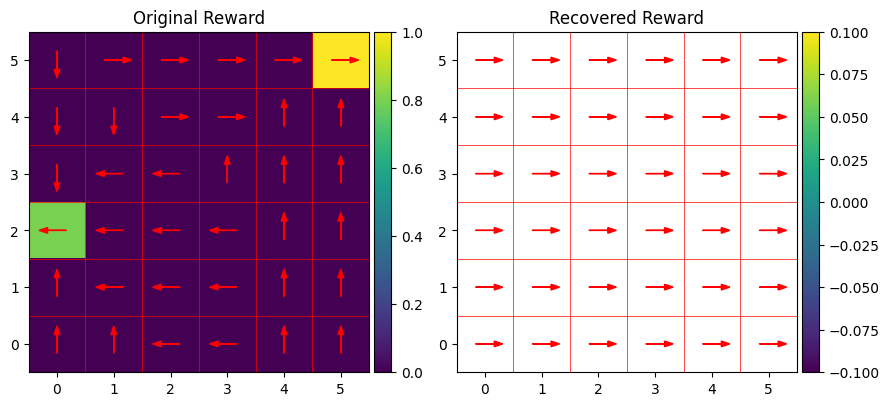

In [15]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.8), color='red')
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Recovered Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.8), color='red')
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()

We can also compare the feature-expectation:

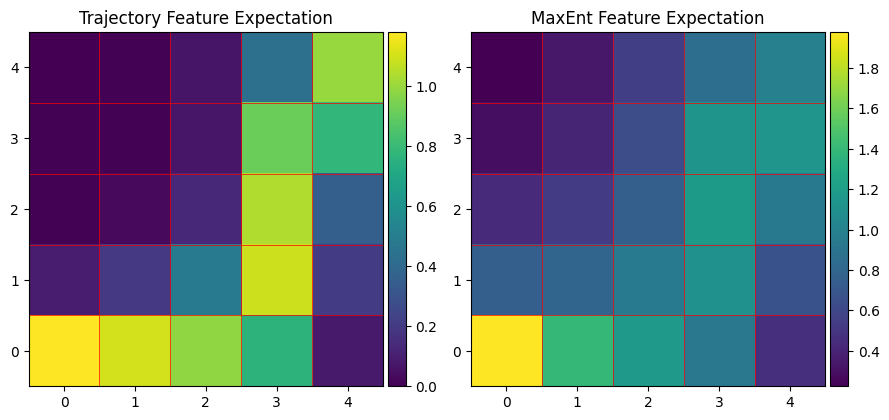

In [17]:
# Note: this code will only work with one feature per state
p_initial = initial_probabilities_from_trajectories(world.n_states, trajectories)
e_svf = compute_expected_svf(world.p_transition, p_initial, terminal, reward_maxent)
e_features = feature_expectation_from_trajectories(features, trajectories)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Trajectory Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, e_features, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('MaxEnt Feature Expectation')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, features.T.dot(e_svf), **style)
fig.colorbar(p, cax=cax)

fig.tight_layout()
plt.show()

## References

- \[Abbel & Ng 2004\]: https://doi.org/10.1145/1015330.1015430
- \[Bishop 2006\]: https://www.springer.com/us/book/9780387310732
- \[Jaynes 1957\]: https://doi.org/10.1103/physrev.106.620
- \[Kivinen et. al. 1997\]: https://doi.org/10.1006/inco.1996.2612
- \[Ng et al. 99\]: https://dl.acm.org/citation.cfm?id=645528.657613
- \[Osa et al. 2018\]: https://arxiv.org/abs/1811.06711
- \[Ziebart et al. 2008\]: http://www.cs.cmu.edu/~bziebart/publications/maximum-entropy-inverse-reinforcement-learning.html
- \[Ziebart 2010\]: https://www.cs.cmu.edu/~bziebart/publications/thesis-bziebart.pdf

Note: Most of these resources are freely available.